In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import logsumexp
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

### 1 Problème jouet
Pour ce premier exercice, vous allez implémenter et tester la regression logistique sur un problème ”jouet”. Ce problème comprend des points étiquetés (x, yi) ∈ R2 × {λ1, λ2}, et les distributions des classes suivent une loi normale, i.e. $λ_1$ ∼ N ($μ_1$, $σ^2_1$ )  et  $λ_2$ ∼ N ($μ_2$, $σ^2_2$ ).

1. Générez cette base de données synthétiques telle que :
- chaque classe contient 300 points
- $λ_1$ ∼ N ((1, 1), 0.7) et $λ_2$ ∼ N ((−1, −1), 0.7)

In [11]:
n = 300
c1 = np.random.normal((1,1), 0.7, (n, 2))
c2 = np.random.normal((-1,-1), 0.7, (n, 2))

In [10]:
labels_1 = np.ones(n) # c1 = 1
labels_2 = np.zeros(n) # c2 = 0

data = np.vstack((c1, c2))
labels = np.hstack((labels_1, labels_2))

2. Affichez le nuage de points pour obtenir un résultat similaire à celui de la figure 1

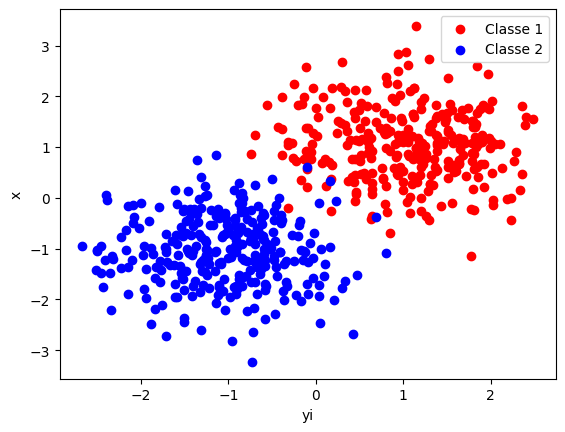

In [9]:
def plot_data():
    plt.scatter(c1[:, 0], c1[:, 1], color='red', label='Classe 1')
    plt.scatter(c2[:, 0], c2[:, 1], color='blue', label='Classe 2')
    plt.legend()
    plt.xlabel("yi")
    plt.ylabel("x")
    plt.show()

plot_data()


Avant d’implémenter votre propre méthode de régression logistique, vous allez tester celle de scikit-learn :

3. Importez la module de régression logistique de scikit-learn 1 et lancer l’entrainement sur la base synthétique que vous venez de créer

In [13]:
log_reg = LogisticRegression(random_state=0).fit(data, labels)

4. Affichez la fonction de décision du modèle, comme montré en figure 2. Pour cela :
- Générez une grille de points 2D
- Rassembler les prédictions du modèle pour chacun des points de cette grille.
- Afficher le nuage de points de la base d’apprentissage
- Afficher les frontières de décisions en utilisant la fonction contourf de Matplotlib.

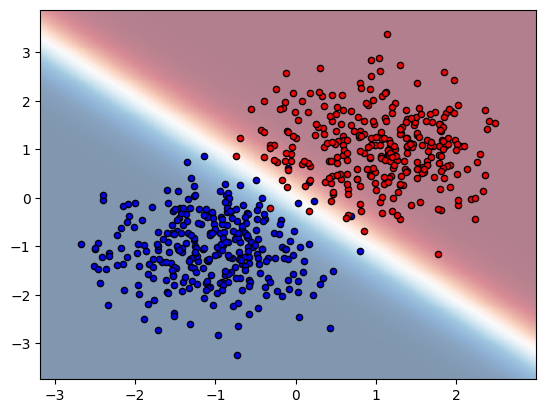

In [14]:
def mesh(X, h=0.02):
    x_min , x_max = X[:, 0]. min() - .5, X[:, 0]. max() + .5
    y_min , y_max = X[:, 1]. min() - .5, X[:, 1]. max() + .5
    xx , yy = np.meshgrid(np.arange(x_min , x_max , h), np.arange(y_min , y_max , h))
    return np.c_[xx.ravel (), yy.ravel ()], xx , yy

xtest_grid , xx , yy = mesh(data)
Z = log_reg.predict_proba(xtest_grid)[:, 0]
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx , yy , Z, cmap=plt.cm.RdBu , alpha =.5)
plt.scatter(data[labels == 0, 0], data[labels == 0, 1], c='b', edgecolors="k", s=20)
plt.scatter(data[labels == 1, 0], data[labels == 1, 1], c='r', edgecolors="k", s=20)
plt.show()

### 2 Régression logistique sur le problème jouet
Vous allez maintenant implémenter votre propre modèle de regression logistique. Pour cela :
1. Implémentez le calcul du coût en complétant la fonction ci-dessous :

In [16]:
def logreg_cost(X, y, w):
    z = X @ w
    cost = -np.sum(z @ y) + np.sum(np.log(1+np.exp(z)))
    # cost = -np.sum(y * z) + np.sum(logsumexp(np.c_[np.zeros_like(z), z], axis=1)) # to avoid "overflow encountered in exp" problem
    return cost

2. Implémentez le calcul du gradient de la fonction de coût en complétant la fonction ci-dessous :

In [15]:
def logreg_grad(X, y, w):
    z = X @ w
    # p = np.exp(z)/(1 + np.exp(z))
    p = 1 / (1 + np.exp(-z))
    # grad = -np.sum((y - p) @ X)
    grad = -X.T @ (y - p)
    return grad

3. Implémentez l’estimation des paramètres du modèle de regression logistique en utilisant la méthode de descente de gradient :

In [17]:
def logreg_descent(X, y, learning_rate =1e-3, max_iter =1000):
    n, d = X.shape
    X = np.concatenate ((X, np.ones((n, 1))), axis =1)
    w = np.random.randn(d+1)
    step = learning_rate
    beta = 0.9 # for backtracking if needed - to tune
    
    costs = np.zeros(max_iter)

    for i in range(max_iter):
        w = w - step*logreg_grad(X, y, w)
        costs[i] = logreg_cost(X, y, w)

    return w, costs


4. Tracez la courbe de l’évolution du coût au fil de l’apprentissage. Commentez ce résultat.

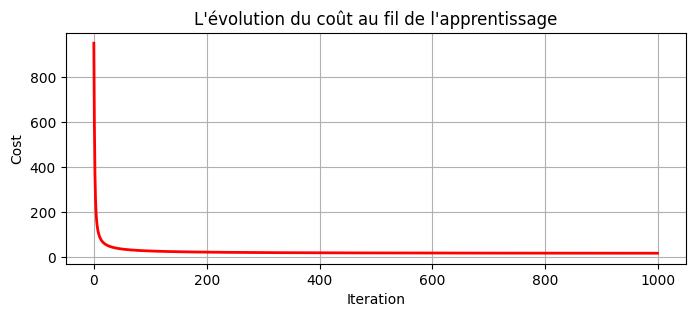

In [20]:
wmin, costs = logreg_descent(data, labels)

plt.figure(figsize=(8, 3))
plt.plot(range(len(costs)), costs, color="red", linewidth=2)
plt.title("L'évolution du coût au fil de l'apprentissage")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:8px; font-family:Arial, sans-serif; line-height:1.6;">
  <p>
    We can see that the cost function decreases significantly within the first 100 iterations and then reaches convergence. This means that the chosen value of 1000 iterations is not the most efficient for this example, and using a tolerance threshold is recommended.
  </p>
</div>

In [21]:
def logreg_descent_bt(X, y, learning_rate=1e-3, max_iter=1000, tol=1e-6, alpha=0.5, beta=0.9):
    n, d = X.shape
    X = np.concatenate((X, np.ones((n, 1))), axis=1) 
    w = np.random.randn(d+1)  
    costs = np.zeros(max_iter)

    for i in range(max_iter):
        grad = logreg_grad(X, y, w)
        step = 1.0  # start with big step

        # Backtracking to find the best step
        while logreg_cost(X, y, w - step * grad) > logreg_cost(X, y, w) - alpha * step * np.linalg.norm(grad)**2:
            step *= beta  # Decreses the step

        w_new = w - step * grad
        costs[i] = logreg_cost(X, y, w_new)

        # Convergence seuil
        if i > 0 and abs(costs[i] - costs[i-1]) < tol:
            print(f"Convergence at {i}th step")
            return w_new, costs[:i+1]  

        w = w_new

    return w, costs

Convergence at 27th step


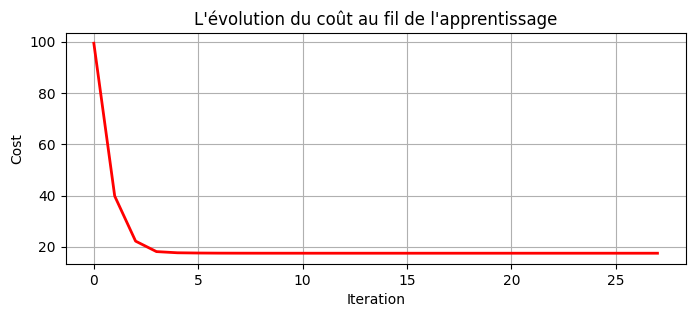

In [22]:
wmin_bt, costs_bt = logreg_descent_bt(data, labels)

plt.figure(figsize=(8, 3))
plt.plot(range(len(costs_bt)), costs_bt, color="red", linewidth=2)
plt.title("L'évolution du coût au fil de l'apprentissage")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:8px; font-family:Arial, sans-serif; line-height:1.6;">
  <p>
    Here, we applied two improvements to the regression function: implementing backtracking to optimize the step size and introducing a tolerance criterion to stop the loop once convergence is reached. As a result, the function completes in 27 iterations, meaning convergence happened faster and unnecessary iterations were avoided.
  </p>
</div>

5. Affichez la fonction de décision résultante comme à l’exercice précédent. Commentez ce résultat

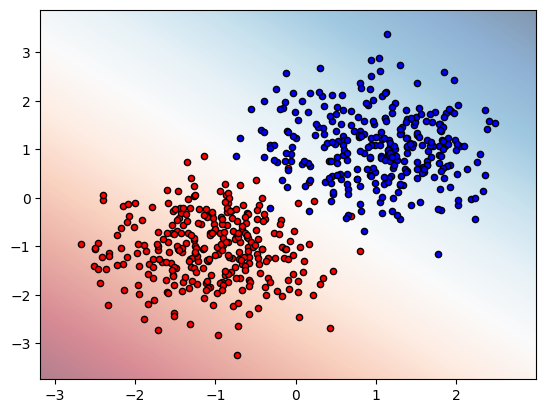

In [23]:
xtest_grid, xx, yy = mesh(data)
xtest_grid = np.concatenate((xtest_grid, np.ones((xtest_grid.shape[0], 1))), axis=1)  # Adiciona bias

Z = xtest_grid @ wmin_bt
Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.5)
plt.scatter(data[labels == 0, 0], data[labels == 0, 1], c='r', edgecolors="k", s=20)
plt.scatter(data[labels == 1, 0], data[labels == 1, 1], c='b', edgecolors="k", s=20)
plt.show()

6. Estimez les performances en généralisation de votre méthode.

In [25]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3, random_state=42)

wmin, costs = logreg_descent(data_train, labels_train)
X = np.concatenate((data_test, np.ones((data_test.shape[0], 1))), axis=1)
preds = (X @ wmin >= 0).astype(int)
accuracy = np.mean(preds == labels_test)
print(f"Accuracy without backtracking: {accuracy:.4f}, Minimum cost: {costs[-1]}\n")

wmin_bt, costs_bt = logreg_descent_bt(data_train, labels_train)
X = np.concatenate((data_test, np.ones((data_test.shape[0], 1))), axis=1)
preds = (X @ wmin_bt >= 0).astype(int)
accuracy = np.mean(preds == labels_test)
print(f"Accuracy with backtracking: {accuracy:.4f}, Minimum cost: {costs_bt[-1]}")

Accuracy without backtracking: 0.9889, Minimum cost: 12.405671247057626

Convergence at 55th step
Accuracy with backtracking: 0.9833, Minimum cost: 10.869162092792521


<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:8px; font-family:Arial, sans-serif; line-height:1.6;">
  <p>
    We can observe that both functions provided almost the same accuracy, indicating that the implemented improvements had little impact on the results for this dataset. This is expected, considering that the cost of both tests converged to a similar minimum value.
  </p>
</div>

### 3 Diagnostique médical
On propose maintenant de tester votre modèle sur un problème réel d’aide au diagnostique de cancer du sein à partir d’images de biopsie à l’aiguille fine. Plusieurs caractéristiques ont été calculées pour décrire les noyaux cellulaires présents sur chaque image. Cette base de données est disponible et documentée dans scikit-learn. Note that the data in this dataset is not normalised.

1. Comparez votre algorithme de régression logistique à l’implémentation de scikit-learn sur ce dataset. Les résultats seront présentés avec des taux de bonne classification moyen et des écart-types.

In [26]:
data = load_breast_cancer()
X, y = data.data, data.target

scaler = StandardScaler()
X_n = scaler.fit_transform(X)


In [27]:
n_runs = 10
accuracy_logreg = []
accuracy_logreg_bt = []
accuracy_sklearn = []

for _ in range(n_runs):
    
    X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.2, random_state=None)
    X_test_b = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)

    ###### logreg_descent ######
    wmin, costs = logreg_descent(X_train, y_train, learning_rate=1e-3, max_iter=1000)
    wmin_bt, costs_bt = logreg_descent(X_train, y_train, learning_rate=1e-3, max_iter=1000)

    y_pred_logreg = (X_test_b @ wmin >= 0).astype(int)
    accuracy_logreg.append(accuracy_score(y_test, y_pred_logreg))
    y_pred_logreg_bt = (X_test_b @ wmin_bt >= 0).astype(int)
    accuracy_logreg_bt.append(accuracy_score(y_test, y_pred_logreg_bt))

    ###### LogisticRegression ######
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred_sklearn = model.predict(X_test)
    accuracy_sklearn.append(accuracy_score(y_test, y_pred_sklearn))

print(f"Régression Logistique (logreg_descent) - Moyenne : {np.mean(accuracy_logreg):.4f}, Écart-type : {np.std(accuracy_logreg):.4f}")
print(f"Régression Logistique (logreg_descent_bt) - Moyenne : {np.mean(accuracy_logreg_bt):.4f}, Écart-type : {np.std(accuracy_logreg_bt):.4f}")
print(f"Régression Logistique (scikit-learn) - Moyenne : {np.mean(accuracy_sklearn):.4f}, Écart-type : {np.std(accuracy_sklearn):.4f}")

Régression Logistique (logreg_descent) - Moyenne : 0.9667, Écart-type : 0.0151
Régression Logistique (logreg_descent_bt) - Moyenne : 0.9693, Écart-type : 0.0163
Régression Logistique (scikit-learn) - Moyenne : 0.9675, Écart-type : 0.0162


2. Comparez maintenant avec un algorithme de regression logistique régularisée en utilisant l’implémentation de scikit-learn

In [28]:
accuracy_sklearn_l2 = []

for _ in range(n_runs):

    X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.2, random_state=None)

    ###### LogisticRegression avec régularisation L2 ######
    model_l2 = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
    model_l2.fit(X_train, y_train)
    y_pred_sklearn_l2 = model_l2.predict(X_test)
    accuracy_sklearn_l2.append(accuracy_score(y_test, y_pred_sklearn_l2))

print(f"Régression Logistique (logreg_descent) - Moyenne : {np.mean(accuracy_logreg):.4f}, Écart-type : {np.std(accuracy_logreg):.4f}")
print(f"Régression Logistique (logreg_descent_bt) - Moyenne : {np.mean(accuracy_logreg_bt):.4f}, Écart-type : {np.std(accuracy_logreg_bt):.4f}")
print(f"Régression Logistique (scikit-learn, sans régularisation) - Moyenne : {np.mean(accuracy_sklearn):.4f}, Écart-type : {np.std(accuracy_sklearn):.4f}")
print(f"Régression Logistique (scikit-learn, régularisation L2) - Moyenne : {np.mean(accuracy_sklearn_l2):.4f}, Écart-type : {np.std(accuracy_sklearn_l2):.4f}")

Régression Logistique (logreg_descent) - Moyenne : 0.9667, Écart-type : 0.0151
Régression Logistique (logreg_descent_bt) - Moyenne : 0.9693, Écart-type : 0.0163
Régression Logistique (scikit-learn, sans régularisation) - Moyenne : 0.9675, Écart-type : 0.0162
Régression Logistique (scikit-learn, régularisation L2) - Moyenne : 0.9711, Écart-type : 0.0188


3. Analysez et commentez les résultats de chaque test

<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:8px; font-family:Arial, sans-serif; line-height:1.6;">
  <p>
    The result with regularization achieved the highest accuracy, showing that coefficient penalization had a positive impact on generalization. Next, the model with backtracking also demonstrated good accuracy. This version of the algorithm proved to be more accurate and efficient than its non-backtracking counterpart. However, the two models with the highest accuracy also exhibited the largest standard deviations, meaning that the ranking of the best accuracies could change upon retraining and testing, as the accuracy values across the four models were very close.
  </p>
</div>